### Module import

In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load image

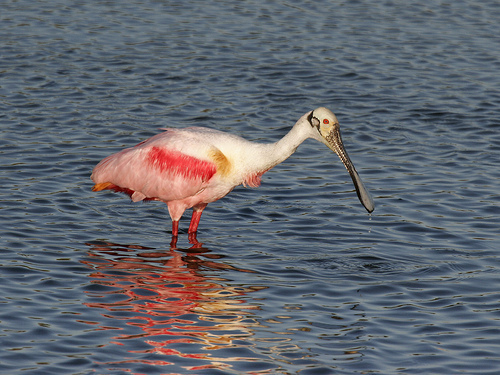

In [2]:
img_dir = 'images'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
img_name = 'water-bird.JPEG'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [3]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

### Load torchvision models and make configs

In [4]:
alexnet = models.alexnet(pretrained=True)
vgg = models.vgg16(pretrained=True)
resnet = models.resnet101(pretrained=True)
densenet = models.densenet161(pretrained=True)
squeezenet = models.squeezenet1_1(pretrained=True)

In [5]:
configs = [
    dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
    dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),
    dict(model_type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation')
]

In [6]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [7]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

/usr/local/lib/python3.6.6/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Show results 

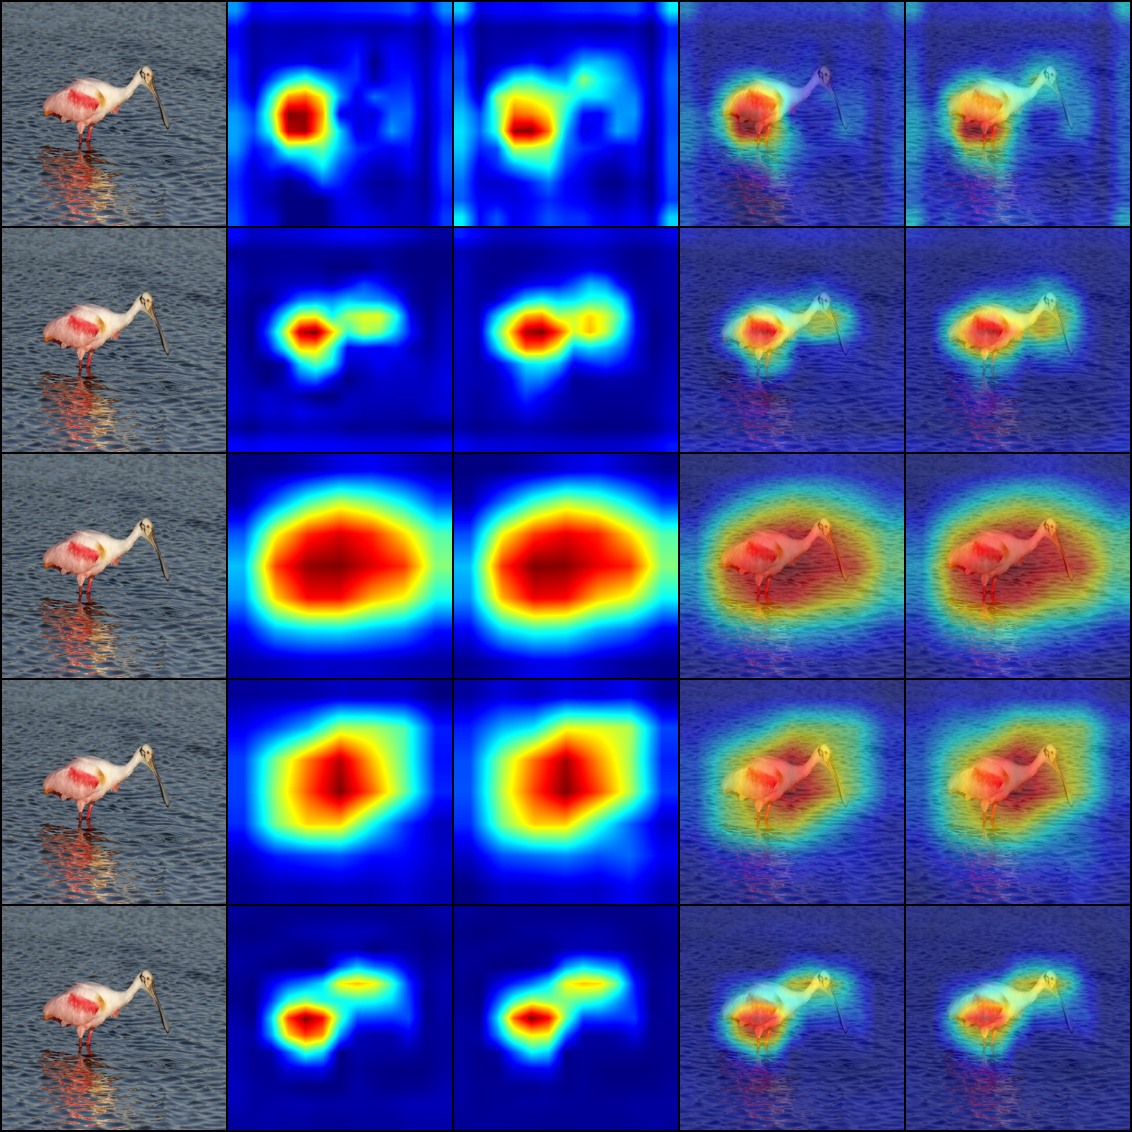

In [8]:
transforms.ToPILImage()(grid_image)